Task:

PFA

A person’s signature is representative of his identity. For us at the Bank, a signed document by a customer is an instruction from him for carrying out an approved transaction for him.

On on-boarding a customer we capture an image of his signature in our systems, and on receiving a signed document (Cheques, DDs, and others) from him we match the signature on the document with the one recorded in the database before proceeding with the instruction.

In the case of skilled forgeries, it becomes very difficult to verify the identity of the customer.

We want you to build a system that can help us distinguish forgeries from actual signatures. This system should be able to study signature parameters as strokes, curves, dots, dashes, writing fluidity & style, in a Writer-Independent manner and create features for identification of the signature.

The system should not use any existing APIs and should be completely self-developed.

How should it work?

The system shall work in 2 steps:

Step 1: Accept & Store Genuine Signature Image: Take actual signature scanned image of the onboarding customer and store it in a database against a unique Customer ID

Step 2: Accept & Compare Signature Images: Accept inputs of Customer ID and corresponding signature image. Compare with the signature stored in DB against the given Customer ID, and return a Confidence Match Score between the two signature images.

This is the code for training the model (Deep learning model)

For this project i used Siamese Network for creating deep learninf model, 

Description is given in reference of GIT documentation, Readme

In [1]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from pathlib import Path

from dataset import SignaturesDataset
from model import SignaturesNetwork, SiameseNetwork
from loss import ContrastiveLoss

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not use_cuda:
    print('No GPU found. Please use a GPU to train your neural network.')

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
genuine_path = Path('sample_Signature/genuine')
forged_path = Path('sample_Signature/forged')
path = Path('sample_Signature')

train = pd.read_csv(path/"train_final.csv")
display(train.head())

,file,owner_id,genuine_sample_number,sample_number,signature_owner_id,signed_file,status
0,NFI-00101001.png,1,1,1,1,genuine/NFI-00101001.png,0
1,NFI-00101001.png,1,1,2,1,genuine/NFI-00102001.png,0
2,NFI-00101001.png,1,1,3,1,genuine/NFI-00103001.png,0
3,NFI-00101001.png,1,1,4,1,genuine/NFI-00104001.png,0
4,NFI-00101001.png,1,1,5,1,genuine/NFI-00105001.png,0


In [4]:
# Load the the dataset from raw image folders

#an = SignaturesDataset(train, genuine_path)
#attrs = vars(an)
#print(attrs)

signatures_dataset = SignaturesDataset(train, genuine_path, training_dir=path, transform="train")
signatures_dataset_test = SignaturesDataset(train, genuine_path, training_dir=path, transform="test")

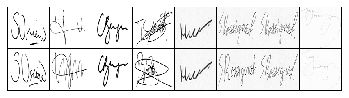

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [5]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(signatures_dataset,
                        shuffle=True,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
batch_size = 32
epochs = 40
learning_rate = 1e-4
alpha = 0.99
show_every_n_batches = 5

In [7]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(signatures_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

test_dataloader = DataLoader(signatures_dataset_test, num_workers=6, batch_size=1, shuffle=True)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [9]:
# Declare Siamese Network
net = SignaturesNetwork()
#net = SiameseNetwork()

net.apply(init_weights)

if use_cuda:
    net = net.cuda()
    net = torch.nn.DataParallel(net)

net.load_state_dict(torch.load("model/model_v4.pt"))

# Decalre Loss Function
margin = 2
criterion = ContrastiveLoss(margin)
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, alpha=alpha, eps=1e-8, weight_decay=0.0005, momentum=0.9)
#optimizer = optim.Adam(net.parameters(),lr = learning_rate )

/home/koushik/.conda/envs/image-segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/koushik/.conda/envs/image-segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0
    original_loss = np.inf
    valid_loss = 0
    total_loss = 0
    
    for epoch in range(epochs):
        
        for i, (img0, img1 , label) in enumerate(train_dataloader):
            #img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            
            total_loss += loss_contrastive.item() * img0.size(0)
            #valid_corrects += torch.sum(preds == target.data)
            iteration_number += 1
            
        total_loss = total_loss/len(train_dataloader.dataset)
        
        if epoch%show_every_n_batches == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, total_loss, valid_loss))
            counter.append(iteration_number)
            loss_history.append(total_loss)
            if total_loss < original_loss:
                print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(original_loss,
                total_loss))
                with open('model/model.pt', 'wb') as pickle_file:
                    torch.save(net.state_dict(), pickle_file)
                original_loss = total_loss
            total_loss = 0
            
    show_plot(counter, loss_history)
    return net

Epoch: 0 	Training Loss: 1.771200 	Validation Loss: 0.000000
Training loss decreased (inf --> 1.771200).  Saving model ...
Epoch: 5 	Training Loss: 1.220257 	Validation Loss: 0.000000
Training loss decreased (1.771200 --> 1.220257).  Saving model ...
Epoch: 10 	Training Loss: 1.220404 	Validation Loss: 0.000000
Epoch: 15 	Training Loss: 1.195536 	Validation Loss: 0.000000
Training loss decreased (1.220257 --> 1.195536).  Saving model ...
Epoch: 20 	Training Loss: 1.208474 	Validation Loss: 0.000000
Epoch: 25 	Training Loss: 1.287482 	Validation Loss: 0.000000
Epoch: 30 	Training Loss: 1.200710 	Validation Loss: 0.000000
Epoch: 35 	Training Loss: 1.268340 	Validation Loss: 0.000000


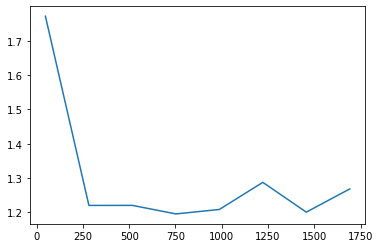

Model Saved Successfully


In [11]:
model = train()
#torch.save(model.state_dict(), "model/model.pt")
print("Model Saved Successfully")

In [12]:
model = net
model.load_state_dict(torch.load("model/model.pt"))

<All keys matched successfully>

In [17]:
accuracy=0
counter=0
correct=0

for i, data in enumerate(test_dataloader,0):
    
    x0, x1, label = data    
    # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
    
    output1, output2 = model(x0.to(device),x1.to(device))
    
    res = nn.Softmax(dim=1)(output1.cuda() - output2.cuda())
    #res = torch.abs(output1.cuda() - output2.cuda())
    label = label[0].tolist()
    label = int(label[0])
    result=torch.max(res,1)[1].data[0].tolist()
    if label == result:
        correct = correct+1
    counter=counter+1
    accuracy=(correct/len(test_dataloader))*100

print("Accuracy:{}%".format(accuracy))

Accuracy:51.26666666666667%


tensor([[0.2465, 0.7535]], device='cuda:0', grad_fn=<SoftmaxBackward>)


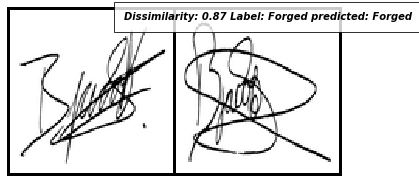

tensor([[0.5387, 0.4613]], device='cuda:0', grad_fn=<SoftmaxBackward>)


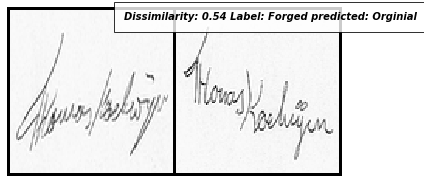

tensor([[0.5786, 0.4214]], device='cuda:0', grad_fn=<SoftmaxBackward>)


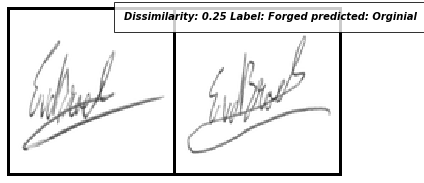

tensor([[0.6215, 0.3785]], device='cuda:0', grad_fn=<SoftmaxBackward>)


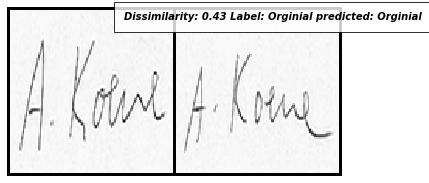

tensor([[0.8737, 0.1263]], device='cuda:0', grad_fn=<SoftmaxBackward>)


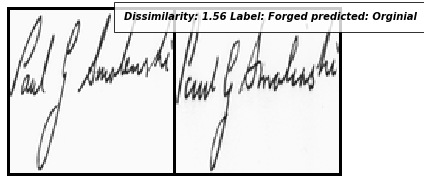

tensor([[0.8433, 0.1567]], device='cuda:0', grad_fn=<SoftmaxBackward>)


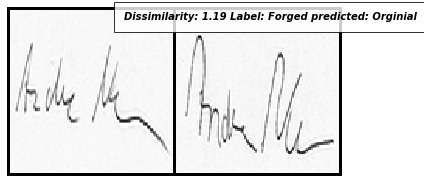

tensor([[0.4683, 0.5317]], device='cuda:0', grad_fn=<SoftmaxBackward>)


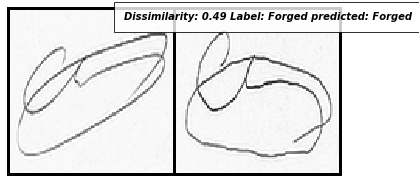

tensor([[0.5294, 0.4706]], device='cuda:0', grad_fn=<SoftmaxBackward>)


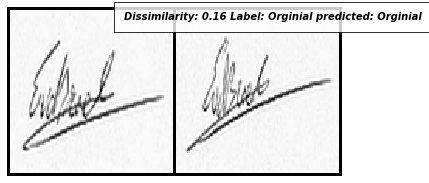

tensor([[0.6978, 0.3022]], device='cuda:0', grad_fn=<SoftmaxBackward>)


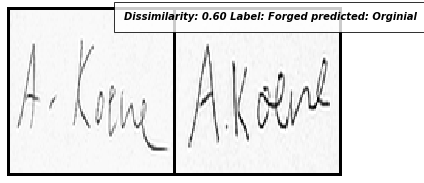

tensor([[0.4031, 0.5969]], device='cuda:0', grad_fn=<SoftmaxBackward>)


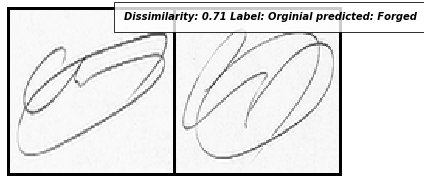

tensor([[0.7652, 0.2348]], device='cuda:0', grad_fn=<SoftmaxBackward>)


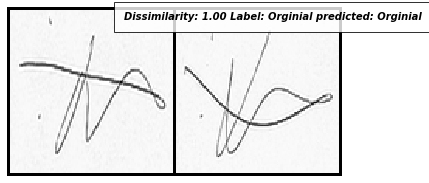

tensor([[0.2224, 0.7776]], device='cuda:0', grad_fn=<SoftmaxBackward>)


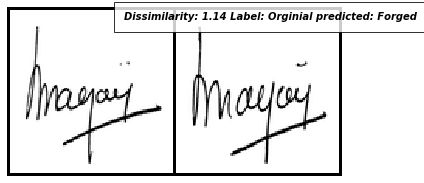

tensor([[0.5700, 0.4300]], device='cuda:0', grad_fn=<SoftmaxBackward>)


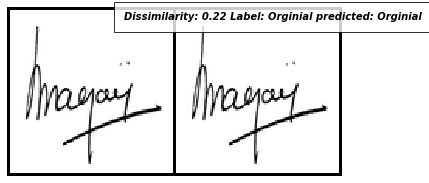

tensor([[0.5357, 0.4643]], device='cuda:0', grad_fn=<SoftmaxBackward>)


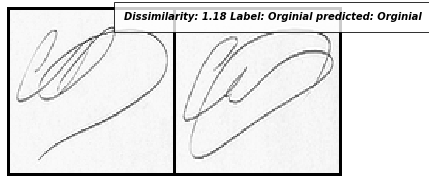

tensor([[0.7816, 0.2184]], device='cuda:0', grad_fn=<SoftmaxBackward>)


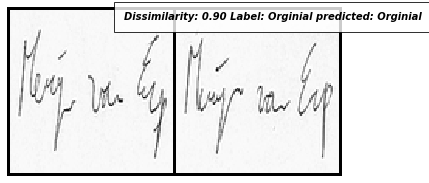

tensor([[0.5916, 0.4084]], device='cuda:0', grad_fn=<SoftmaxBackward>)


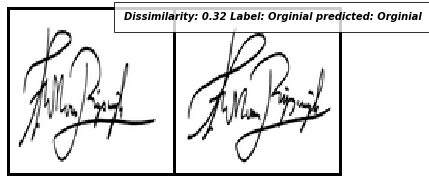

tensor([[0.5806, 0.4194]], device='cuda:0', grad_fn=<SoftmaxBackward>)


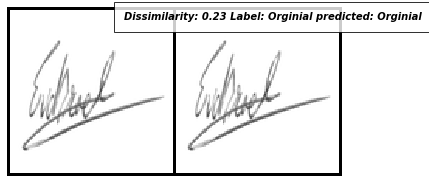

tensor([[0.8245, 0.1755]], device='cuda:0', grad_fn=<SoftmaxBackward>)


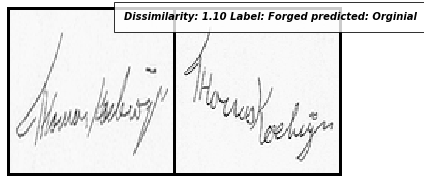

tensor([[0.3875, 0.6125]], device='cuda:0', grad_fn=<SoftmaxBackward>)


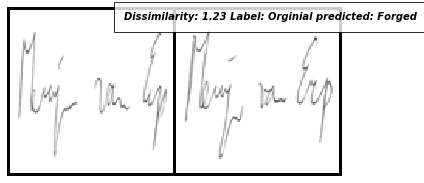

tensor([[0.6557, 0.3443]], device='cuda:0', grad_fn=<SoftmaxBackward>)


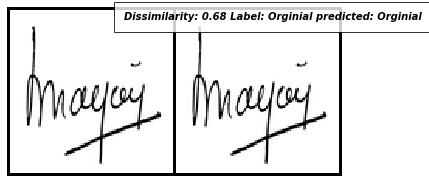

In [18]:
# Print the sample outputs to view its dissimilarity
counter=0
list_1 = torch.FloatTensor([[1]])
list_0 = torch.FloatTensor([[0]])

for i, data in enumerate(test_dataloader,0):
    x0, x1, label = data
    concatenated = torch.cat((x0,x1),0)
    output1, output2 = model(Variable(x0).to(device),Variable(x1).to(device))
    
    res = nn.Softmax(dim=1)(output1.cuda() - output2.cuda())
    eucledian_distance_1 = F.pairwise_distance(output2, output1)
    #eucledian_distance_2 = (output2 - output1).pow(2).sum(1)
    result=torch.max(res,1)[1].data[0].tolist()
    print(res)
    #print(eucledian_distance_1.item())
    #print(eucledian_distance_2)
    
    if result==0:
        pred_label="Orginial"
    else:
        pred_label="Forged"
        
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {} predicted: {}'.format(eucledian_distance_1.item(),label, pred_label))
    counter = counter + 1
    if counter ==20:
        break